Create a folder for the data/results:

In [ ]:
import os

if not os.path.isdir('data'):
    os.makedirs('data')

#### Data import

The function **import_and_preprocess_ENERCOOP_load_profiles** beneath is used to transform the file **all_load_profiles.json** into a dataframe. Additionally, several date/time-related features are engineered (line 19-26). This function should only be used once to create the dataframe and export it as a parquet file.

In [ ]:
#metSeason_dict: used to determine the meteorological season
metSeason_dict = \
    {item: 'Spring' for item in [3, 4, 5]} | \
    {item: 'Summer' for item in [6, 7, 8]} | \
    {item: 'Fall' for item in [9, 10, 11]} | \
    {item: 'Winter' for item in [12, 1, 2]}

#weekend_dict: used to determine whether or not a day is part of the weekend
weekend_dict = \
    {item: False for item in range(5)} | \
    {item: True for item in [5, 6]}


def import_and_preprocess_ENERCOOP_load_profiles(path):
    ENERCOOP_df = pd.read_json(path)
    ENERCOOP_df = pd.melt(ENERCOOP_df, id_vars = 'Date', value_vars = ENERCOOP_df.columns[1:].tolist(), var_name = 'Profile', value_name = 'Consumed energy [Wh]')
    ENERCOOP_df['Profile'] = ENERCOOP_df['Profile'].astype(int)
    ENERCOOP_df['Date'] = pd.to_datetime(ENERCOOP_df['Date'])
    ENERCOOP_df[[
            'Year',                         'Meteorological season',                                'Month',                                'Week of the year',
            'Day of the month',             'Weekday',                                              'Hour of the day',                      'Weekend'
    ]] = \
        pd.DataFrame([
            ENERCOOP_df['Date'].dt.year,    ENERCOOP_df['Date'].dt.month.replace(metSeason_dict),   ENERCOOP_df['Date'].dt.month_name(),    ENERCOOP_df['Date'].dt.isocalendar().week,
            ENERCOOP_df['Date'].dt.day,     ENERCOOP_df['Date'].dt.day_name(),                      ENERCOOP_df['Date'].dt.hour + 1,        ENERCOOP_df['Date'].dt.dayofweek.replace(weekend_dict)
        ]).T.values
    ENERCOOP_df = ENERCOOP_df[['Profile', 'Date'] + ENERCOOP_df.columns[3:].tolist() + ['Consumed energy [Wh]']]
    intCols = ['Profile', 'Year', 'Week of the year', 'Day of the month', 'Hour of the day']
    ENERCOOP_df[intCols] = ENERCOOP_df[intCols].astype(int)
    ENERCOOP_df['Weekend'] = ENERCOOP_df['Weekend'].astype('bool')
    return ENERCOOP_df

The code below creates and exports the parquet file. Enter the path to **all_load_profiles.json** and run the cell once. This cell can be skipped from then on or commented out.

In [ ]:
import pandas as pd

path = r'path\to\all_load_profiles.json'
ENERCOOP_df = import_and_preprocess_ENERCOOP_load_profiles(path)
ENERCOOP_df.to_parquet(r'data/ENERCOOP_load_profiles.parquet.gzip', compression = 'gzip')

Once the **data** directory and the parquet file have been created the notebook can be started from here. In the cell below the ENERCOOP load profiles are imported and restructured.

In [ ]:
import pandas as pd

ENERCOOP_df = pd.read_parquet(r'data/ENERCOOP_load_profiles.parquet.gzip')
energy_df = ENERCOOP_df.pivot_table(values = 'Consumed energy [Wh]', index = 'Profile', columns = ['Date', 'Meteorological season', 'Month', 'Day of the month', 'Hour of the day'])

Take a look at the dataframes:

In [ ]:
display('ENERCOOP_df', ENERCOOP_df)
display('energy_df', energy_df)

#### Data preparation

Below, the data is normalized for the clustering procedure since the distance measures used in clustering are affected by the scale of the variables.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

energyNorm_df = energy_df.copy()
energyNorm_df[:] = MinMaxScaler().fit_transform(energy_df.T).T

Take a look at the normalized data:

In [ ]:
display('energyNorm_df', energyNorm_df)

#### Agglomerative Clustering

Below, hierarchical/agglomerative clustering is performed. First, the number of clusters is selected, then the clustering (encoded as a linkage matrix Z) is returned. In the last step, a dendrogram is plotted and exported to the **data** directory.

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, maxdists, fcluster
import matplotlib.pyplot as plt

clusterCount = 11
Z = linkage(energyNorm_df, method = 'ward')
optDist = (maxdists(Z)[1 - clusterCount] + maxdists(Z)[- clusterCount])/2   #used for the horizontal line

plt.figure(figsize = (18, 12), facecolor = 'w')
dendrogram(Z, show_contracted = True)
plt.axhline(y = optDist, color = 'r', linestyle = 'dashed', label = f'Number of clusters = {clusterCount}')
plt.xticks([])
plt.ylabel('Cluster distance', fontsize = 16)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig(f'data//Dendrogram.png')
plt.close()

The assigned cluster labels can be extracted from the linkage matrix with the **fcluster** function. We set the parameter **t** to the number of clusters we want and choose 'maxclust' as the criterion. This way, the dendrogram is cut off such that we get the desired number of clusters (alternatively, we could choose a distance for **t** and set the criterion to 'distance', this way we would get a number of clusters that matches a cut through the dendrogram at the specified distance). The output below is equal to **sklearn.cluster.AgglomerativeClustering().fit_predict(...)**, thus, we do not need sklearn.

In [ ]:
labels = fcluster(Z, t = clusterCount, criterion = 'maxclust')

The function below is used to create heatmaps.

In [ ]:
def plot_heatmap(df, title = None, use_monthly_xticks = True):
    fig = plt.figure(figsize = (10, 6), facecolor = 'w')
    sns.heatmap(df)
    plt.title(title, fontsize = 16)
    plt.xlabel('Month', fontsize = 16)
    if use_monthly_xticks:
        plt.xticks(ticks = np.arange(15, 365, 30), labels = df.columns.get_level_values(level = 0).unique(), fontsize = 12)
    plt.ylabel('Hour of the day', fontsize = 16)
    plt.yticks(fontsize = 12, rotation = 0)
    plt.tight_layout()
    plt.close()
    return fig

A heatmap is created for every cluster and exported to the **data** directory.

In [ ]:
from tqdm.notebook import tqdm  #used for the progress bar
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

months = list(calendar.month_name)[1:]  #ordered list of months (January - December)

for label in tqdm(np.unique(labels)):
    tempCluster_df = energyNorm_df[labels == label].copy()  #filter out profiles by label
    tempCluster_df = tempCluster_df.melt().pivot_table(values = 'value', index = 'Hour of the day', columns = ['Month', 'Day of the month'])    #restructure dataframe
    tempCluster_df = tempCluster_df[months] #sort columns by month

    # Plot heatmaps
    title = f'Cluster Nr. {label}: {round(100*sum(labels == label)/len(labels), 2)} % of all profiles'
    fig = plot_heatmap(tempCluster_df, title)
    fig.savefig(f'data//Cluster_Nr_{label}.png')

#### Data synthesis

A GAN is used to create synthetic data. First, a cluster and a meteorological season are selected (since we want the data to be somewhat similar). The dataframe is then converted into a numpy array and reshaped into a format ('day', 'hour', 'profile'). E.g. a shape of (90, 24, 62) means that there are 90 days, each with 24 hours, for each of the 62 selected profiles; this equals $90*24*60=129600$ values/data points.

For the **max_sequence_len**, 24 is chosen (such that a sequence equals the values of one day).

! Further experimenting with the parameters is needed, but very time consuming !

In [ ]:
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

clusterID = 9
metSeason = 'Winter'

cluster_df = energy_df.loc[labels == clusterID, energy_df.columns.get_level_values('Meteorological season') == metSeason].T  #filter by label and season
cluster_arr = cluster_df.to_numpy().reshape(-1, 24, cluster_df.shape[1])

model = DGAN(DGANConfig(
    max_sequence_len = cluster_arr.shape[1],
    sample_len = 1,
    apply_example_scaling = False,
    generator_learning_rate = 1e-4,
    discriminator_learning_rate = 1e-4,
    batch_size = cluster_arr.shape[0],
    epochs = 10000
))

The model is then trained:

In [ ]:
model.train_numpy(
    cluster_arr,
    feature_types = [OutputType.CONTINUOUS]*cluster_arr.shape[2]
)

Now, synthetic data can be generated. The 'cluster_arr.shape[0]' (which is 90 in this example) inside **generate_numpy** indicates that we want 90 days worth of data for each feature/profile. As I understand it right now, the code above generates multiple profiles for a single day and then joins them together, thus, an overall trend during the Winter period would be missed. Increasing the time intervall ('max_sequence_len' in the model initialization) leads to longer computation times.

In [ ]:
_, synthetic_arr = model.generate_numpy(cluster_arr.shape[0])
synthetic_df = cluster_df.copy()
synthetic_df[:] = synthetic_arr.reshape(-1, cluster_df.shape[1])

Take a look at the synthetic data:

In [ ]:
display(synthetic_df)

Take a look at the correlations between the repsective columns/profiles of 'cluster_df' and 'synthetic_df':

In [ ]:
cluster_df.corrwith(synthetic_df, axis = 0).plot()
plt.title('Correlations')
plt.savefig(f'data//Cluster_Nr_{clusterID}_Winter_Correlations.png')
plt.show()

Take a look at the heatmaps of 'cluster_df' and 'synthetic_df':

In [ ]:
heatmapSynthetic_df = synthetic_df.T.melt().pivot_table(values = 'value', index = 'Hour of the day', columns = ['Month', 'Day of the month'])
fig = plot_heatmap(heatmapSynthetic_df, title = 'Synthetic Winter', use_monthly_xticks = False)
fig.savefig(f'data//Cluster_Nr_{clusterID}_Winter_Synthetic.png')
fig.show()

In [ ]:
heatmapCluster_df = cluster_df.T.melt().pivot_table(values = 'value', index = 'Hour of the day', columns = ['Month', 'Day of the month'])
plot_heatmap(heatmapCluster_df, title = 'Real Winter', use_monthly_xticks = False)
fig.savefig(f'data//Cluster_Nr_{clusterID}_Winter_Real.png')
fig.show()

#### NEW

In [1]:
from sklearn.preprocessing import minmax_scale

def scale(group, col):
    group[col] = minmax_scale(group[col])
    return group

In [2]:
import pandas as pd

ENERCOOP_df = pd.read_parquet(r'data/ENERCOOP_load_profiles.parquet.gzip')
ENERCOOPNorm_df = ENERCOOP_df.groupby('Profile').apply(scale, col = 'Consumed energy [Wh]')

In [3]:
import numpy as np

df = ENERCOOPNorm_df.groupby(['Profile', 'Meteorological season', 'Hour of the day', 'Weekend']).agg({'Consumed energy [Wh]': np.mean})
df.reset_index(inplace = True)
df['Hour of the day'] = df['Hour of the day'].astype(str)
conditions = [
    df['Hour of the day'] ==  '1', df['Hour of the day'] ==  '2', df['Hour of the day'] ==  '3', df['Hour of the day'] ==  '21', df['Hour of the day'] ==  '22', df['Hour of the day'] ==  '23', True
]
choices = [df['Hour of the day'] + item for item in ['st hour', 'nd hour', 'rd hour', 'st hour', 'nd hour', 'rd hour', 'th hour']]
df['Mean scaled consumed energy'] = df['Meteorological season'] + np.where(df['Weekend'] == True, ', weekend, ', ', weekday, ') + np.select(conditions, choices)
df = df.pivot_table(values = 'Consumed energy [Wh]', index = 'Profile', columns = 'Mean scaled consumed energy')

In [4]:
seasons = ['Spring', 'Fall', 'Summer', 'Winter']
dayTypes = ['weekday', 'weekend']
hours = ['1st', '2nd', '3rd'] + [f'{item}th' for item in range(4, 21)] + ['21st', '22nd', '23rd'] + ['24th']
cols = [f'{season}, {dayType}, {hour} hour' for season in seasons for dayType in dayTypes for hour in hours]
df = df[cols]

In [5]:
energyNorm_df = ENERCOOPNorm_df.pivot_table(values = 'Consumed energy [Wh]', index = 'Profile', columns = 'Date')

In [6]:
all_labels = []

from tqdm.notebook import tqdm
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
from math import ceil
import seaborn as sns


for clusterCount in tqdm(range(4, 21)):
    model = TimeSeriesKMeans(n_clusters = clusterCount, metric = 'dtw', max_iter = 10, n_jobs = -1, random_state = 42)
    labels = model.fit_predict(df)
    all_labels.append(labels)

    fig, axes = plt.subplots(nrows = ceil(clusterCount/3), ncols = 3, figsize = (36, ceil(clusterCount/3)*8), facecolor = 'w')
    for idx, ax in enumerate(axes.flat):
        if idx < clusterCount:
            temp_df = energyNorm_df[labels == idx]
            sns.heatmap(temp_df, cbar = False, ax = ax)
            plt.sca(ax)
            plt.title(f'Cluster Nr. {idx}: {round(100*sum(labels == idx)/len(labels), 2)} % of all profiles ({sum(labels == idx)})', fontsize = 24)
            plt.xlabel(None)
            plt.xticks([])
            plt.ylabel(None)
            plt.yticks([])
            plt.tight_layout()
            plt.close()
    fig.savefig(f'{clusterCount} clusters')

  0%|          | 0/17 [00:00<?, ?it/s]

In [19]:
import pickle

with open('all_labels.pickle', 'wb') as outfile:
    pickle.dump(all_labels, outfile)

#### Moving Window

<AxesSubplot: xlabel='Date'>

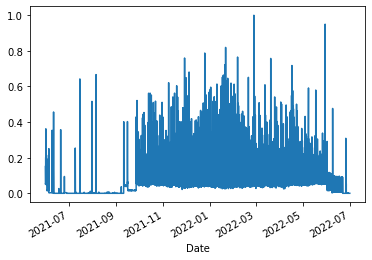

<AxesSubplot: xlabel='Date'>

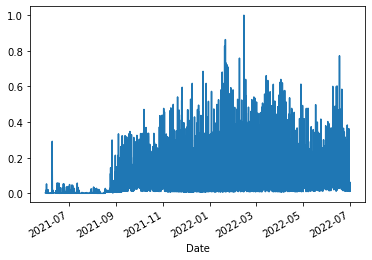

<AxesSubplot: xlabel='Date'>

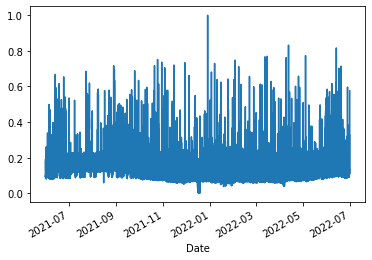

In [41]:
display(energyNorm_df.iloc[0].plot());
plt.show()
plt.close()
display(energyNorm_df.iloc[1].plot())
plt.show()
plt.close()
display(energyNorm_df.iloc[2].plot())
plt.show()
plt.close()

In [29]:
energyNormSmooth_df = energyNorm_df.rolling(window = 24, axis = 1).mean().iloc[:, 23:]

<AxesSubplot: xlabel='Date'>

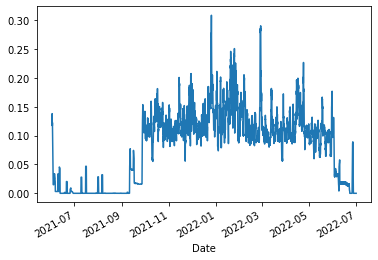

<AxesSubplot: xlabel='Date'>

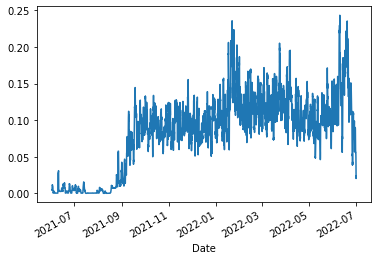

<AxesSubplot: xlabel='Date'>

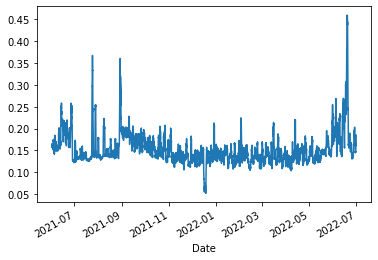

In [42]:
display(energyNormSmooth_df.iloc[0].plot());
plt.show()
plt.close()
display(energyNormSmooth_df.iloc[1].plot())
plt.show()
plt.close()
display(energyNormSmooth_df.iloc[2].plot())
plt.show()
plt.close()

In [45]:
energyNormSmooth_2_df = energyNorm_df.rolling(window = 7*24, axis = 1).mean().iloc[:, 7*24 - 1:]

<AxesSubplot: xlabel='Date'>

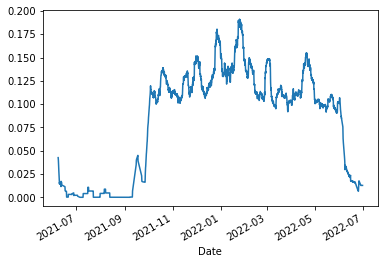

<AxesSubplot: xlabel='Date'>

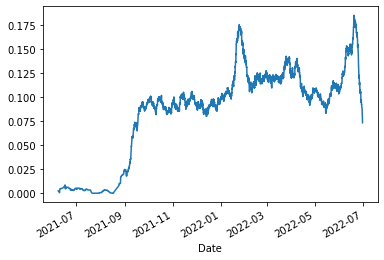

<AxesSubplot: xlabel='Date'>

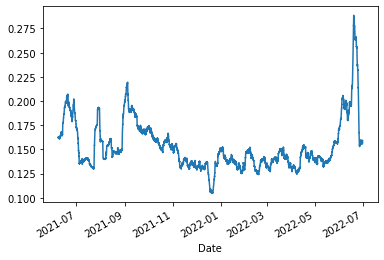

In [46]:
display(energyNormSmooth_2_df.iloc[0].plot());
plt.show()
plt.close()
display(energyNormSmooth_2_df.iloc[1].plot())
plt.show()
plt.close()
display(energyNormSmooth_2_df.iloc[2].plot())
plt.show()
plt.close()

In [44]:
all_labels_2 = []

from tqdm.notebook import tqdm
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
from math import ceil
import seaborn as sns


for clusterCount in tqdm(range(4, 21)):
    model = TimeSeriesKMeans(n_clusters = clusterCount, max_iter = 10, n_jobs = -1, random_state = 42)
    labels = model.fit_predict(energyNormSmooth_df)
    all_labels_2.append(labels)

    fig, axes = plt.subplots(nrows = ceil(clusterCount/3), ncols = 3, figsize = (36, ceil(clusterCount/3)*8), facecolor = 'w')
    for idx, ax in enumerate(axes.flat):
        if idx < clusterCount:
            temp_df = energyNorm_df[labels == idx]
            sns.heatmap(temp_df, cbar = False, ax = ax)
            plt.sca(ax)
            plt.title(f'Cluster Nr. {idx}: {round(100*sum(labels == idx)/len(labels), 2)} % of all profiles ({sum(labels == idx)})', fontsize = 24)
            plt.xlabel(None)
            plt.xticks([])
            plt.ylabel(None)
            plt.yticks([])
            plt.tight_layout()
            plt.close()
    fig.savefig(f'Moving average {clusterCount} clusters')

  0%|          | 0/17 [00:00<?, ?it/s]